# MOF Recommender System: Constructing a matrix with Henry coefficients from the Sparsity Matrix

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pprint
import os
import seaborn as sns
from scipy import stats
import scipy

In [2]:
MIN_UNIQUE_ISOTHERMS = 4

### Load in the Sparsity Matrix and other relevant files

In [3]:
material_gas_df = pd.read_csv('data/sparsity_matrix_' + str(MIN_UNIQUE_ISOTHERMS) + '_min_unique_isotherms.csv')
material_gas_df.set_index(list(material_gas_df)[0], inplace=True)
material_gas_df[material_gas_df.columns[0:5]][0:5]

,CURLTUGMZLYLDI-UHFFFAOYSA-N_298K,IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K,VNWKTOKETHGBQD-UHFFFAOYSA-N_298K,MYMOFIZGZYHOMD-UHFFFAOYSA-N_298K,QQONPFPTGQHPMA-UHFFFAOYSA-N_298K
Unnamed: 0,,,,,
NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1,1,1,0,1
NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,1,1,1,1,1
NIST-MATDB-453276ee992ed07dc207ed08b2b221ce,1,1,1,1,0
NIST-MATDB-1b85b1862d4e9cc2e0f46d0e2698ab79,1,1,1,1,0
NIST-MATDB-991daf7313251e7e607e2bab2da57e33,1,1,1,1,1


In [4]:
host = "adsorption.nist.gov"
url = "https://" + host + "/isodb/api/gases.json"
gas_data = json.loads(requests.get(url).content)

key_to_gas = {}
for gas in gas_data:
    key_to_gas[gas['InChIKey']] = gas['name']
gas_to_key = dict(map(reversed, key_to_gas.items()))

url = "https://" + host + "/isodb/api/materials.json"
material_data = json.loads(requests.get(url).content)

key_to_material = {}
for material in material_data:
    key_to_material[material['hashkey']] = material['name']
material_to_key = dict(map(reversed, key_to_material.items()))

In [5]:
with open('data/material_gas_to_filename.json') as infile:
    material_gas_to_filename = json.load(infile)

### We will need a function to convert the units of the isotherms for consistency's sake

#### First we need to be able to compute the molecular weight of the adsorbates

In [6]:
# Lets start by getting the molecular formula in a dictionary:
url = "https://adsorbents.nist.gov/isodb/api/gas/"

inchikey_to_formula = {}
for inchikey_temp in material_gas_df.columns:
    inchikey = inchikey_temp.split('_')[0]
    gas_data = json.loads(requests.get(url + inchikey + '.json').content)
    inchikey_to_formula[inchikey] = gas_data['formula']

# Lets also load in the atomic masses of each element:
atomic_masses = pd.read_csv('data/atomicmasses.csv')

In [7]:
def formula_to_mw(formula):
    # This splits the formula up into elements plus their frequency
    start_i = 0
    elements = []
    for end_i, letter in enumerate(formula[1:], start=1):
        if letter.isupper():
            elements.append([start_i, end_i])
            start_i = end_i
    elements.append([start_i, len(formula)])
       
    # This calculates the molecular weight of each type of element
    total_mw = 0
    for element in elements:
        form = formula[element[0]:element[1]]
        for i, letter in enumerate(form):
            if letter.isdigit():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form[:i]]['mass'])
                total_mw = total_mw + element_mw * np.int(form[i:])
                break
            if form.isalpha():
                element_mw = np.float(atomic_masses[atomic_masses.atom == form]['mass'])
                total_mw = total_mw + element_mw
                break
    return total_mw

assert formula_to_mw('N2O') == (2 * np.float(atomic_masses[atomic_masses.atom == 'N']['mass']) 
                                + np.float(atomic_masses[atomic_masses.atom == 'O']['mass']))
assert formula_to_mw('CH3OH') == (np.float(atomic_masses[atomic_masses.atom == 'C']['mass'])
                                  + np.float(atomic_masses[atomic_masses.atom == 'O']['mass'])
                                  + 4 * np.float(atomic_masses[atomic_masses.atom == 'H']['mass']))

In [8]:
# Takes in the filename of an isotherm (stored in the isotherm's `.json` file), 
#  reads it and converts units to bar (for pressure) and mmol/g (for adsorption) if needed.
# Returns pressure and adsorption in np.arrays
# An example of use is:
#     `pressure, adsorption = read_isotherm_and_convert_units('10.1002adfm.200500561.Isotherm4')
def read_isotherm_and_convert_units(isotherm_filename):
    with open('isotherms/' + isotherm_filename + '.json') as infile:
        isotherm_data = json.load(infile)
    # Pressure Units    
    pUnit = isotherm_data['pressureUnits']
    assert pUnit == 'bar'
    
    # Adsorption Units
    aUnit = isotherm_data['adsorptionUnits']
    assert aUnit in ['cm3(STP)/g','g/g','mg/g','ml/g','mmol/g','mmol/kg','mol/g','wt%']
    
    aConversion = 0.0
    if aUnit == 'mmol/g':
        aConversion = 1.0
    elif aUnit == 'mmol/kg':
        aConversion = 1.0 / 1000.0
    elif aUnit == 'mol/g':
        aConversion = 1000.0
    elif aUnit == 'wt%':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw * 0.01
    elif aUnit == 'g/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1000.0 / mw
    elif aUnit == 'ml/g' or aUnit == 'cm3(STP)/g':
        aConversion = 1.0 / 22.4
    elif aUnit =='mg/g':
        inchikey = isotherm_data['adsorbates'][0]['InChIKey']
        mw = formula_to_mw(inchikey_to_formula[inchikey])
        aConversion = 1.0 / mw
    else:
        raise Exception('Something went horribly wrong with {}'.format(isotherm_filename))
    
    adsorption = []
    pressure = []
    for data_point in isotherm_data['isotherm_data']:
        pressure.append(data_point['pressure'])
        adsorption.append(data_point['species_data'][0]['adsorption'] * aConversion)
    return np.array(pressure), np.array(adsorption)

### We need a function to extract Henry coefficients from adsorption isotherms

In [9]:
def extract_henry_coeff(pressure, adsorption, verbose=False):
    # Usage example: H, RMSE = extract_henry_coeff(pressure[:5], adsorption[:5], False)
    #  Does not find the optimal number of points to use to extract the initial linear slope of adsorption isotherm curve
    assert len(pressure) == len(adsorption), "Inconsistent number of data points in pressure and adsorption."
    
    if len(pressure) > 1:
        x0 = [(adsorption[-1] - adsorption[0]) / (pressure[-1] - pressure[0])]
    else:
        if pressure[0] == 0:
            raise Exception("Trying to fit a curve to one data point at 0-pressure.")
        x0 = [adsorption[0]/(pressure[0])]
        
    def fit_func(x, pressure, adsorption):
        total_sum = np.sum([(x[0] * pressure[i] - adsorption[i])**2 for i in range(len(pressure))])
        return total_sum
    def fit_func2(h, pressure, adsorption):
        return adsorption - pressure * h
    #res = scipy.optimize.minimize(fit_func, x0, args=(pressure, adsorption), method='Nelder-Mead', options={'disp': verbose, 'maxiter': maxiter, 'maxfev': maxfev})
    res = scipy.optimize.least_squares(fit_func2, x0, args=(pressure, adsorption), max_nfev=10000)
    
    if not res.success:
        raise Exception('Something went wrong with optimization procedure!\n{}\n{}'.format(res.message, res.status))
    
    return res.x[0], np.sqrt(np.sum(res.fun**2) / len(pressure))

H, RMSE = extract_henry_coeff([0, 4], [0, 2], True)
assert np.isclose(0.5, H)

In [10]:
def find_optimal_henry(isotherm_filename, max_rmse):
    assert os.path.isfile('isotherms/' + isotherm_filename + '.json'), "File does not exist."
    
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    n_del = 0
    # If the first pressure point is 0.1% of the total pressure range we get rid of it
    #  because of unreliable digitization
    while np.abs(pressure[0]/(pressure[-1]-pressure[0])) < 0.01:
        pressure = np.delete(pressure, 0)
        adsorption = np.delete(adsorption, 0)
        n_del += 1
        if len(pressure) == 1:
            break
            
    assert not any(pressure < 0) and not any(adsorption < 0), "Pressure or Adsorption contains negative values"
    
    n = len(pressure)
    if n == 0:
        raise Exception('No data points left in the adsorption isotherm')
    
    while n != 0:
        H, RMSE = extract_henry_coeff(pressure[:n], adsorption[:n])
        #assert not np.isclose(np.max(adsorption), 0)
        if RMSE/np.max(adsorption[:n]) < max_rmse:
            break
        n -= 1
    return H, RMSE, n, n_del
h, rmse, n, n_del = find_optimal_henry('10.8888jp206959k.Isotherm17', 0.005)
h

0.30744386130947254

### Lets write a function fitting the data to a Langmuir model, in which we can extract the Henry coefficient as well

In [11]:
def fit_langmuir(pressure, adsorption, verbose=False):
    assert type(verbose) == bool
    np.seterr(all='raise')
    M0 = np.max(adsorption) * 1.1
    if pressure[0] == 0:
        H0 = adsorption[1]/(pressure[1]+1e-16)
        if H0 < 0:
            H0 = 0.0
        K0 = H0 / M0
    else:
        H0 = adsorption[0]/(pressure[0]+1e-16)
        if H0 < 0:
            H0 = 0.0
        K0 = H0 / M0
    
    params = [M0, K0]
    bounds = (0.0, np.inf)
    
    def langmuir(x, pressure, adsorption):
        try:
            y = x[0] * x[1] * pressure / (1.0 + x[1] * pressure)
        except Exception as e:
            print(e)
            print('-------------------------------------------')
        return adsorption - (x[0] * x[1] * pressure / (1.0 + x[1] * pressure))
    #res = scipy.optimize.minimize(fit_func, x0, args=(pressure, adsorption), method='Nelder-Mead', options={'disp': verbose, 'maxiter': maxiter, 'maxfev': maxfev})
    res = scipy.optimize.least_squares(langmuir, params, args=(pressure, adsorption), bounds=bounds, max_nfev=100000)
    if not res.success:
        raise Exception('Something went wrong with optimization procedure!\n{}\n{}'.format(res.message, res.status))
    
    H = res.x[0] * res.x[1]
    RMSE = np.sqrt(np.sum(res.fun**2) / len(pressure))
    return H, RMSE, res.x[0], res.x[1]

In [12]:
def find_optimal_henry_langmuir(isotherm_filename):
    assert os.path.isfile('isotherms/' + isotherm_filename + '.json'), "File does not exist."
    
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    n_del = 0
    #assert not any(pressure < 0) and not any(adsorption < 0), "Pressure or Adsorption contains negative values"
    
    H, RMSE, M, K = fit_langmuir(pressure, adsorption, True)
    return H, RMSE, RMSE/np.max(adsorption), n_del, M, K
#h, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir('10.8888jp206959k.Isotherm17')
h, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir('10.1039B807470d.isotherm9')
h

0.2284329895255021

## Outliers that were removed:

In [13]:
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-297c8ffe0f482757db45335130e02770'].remove('10.1007s11224-012-0120-1.isotherm33')
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-297c8ffe0f482757db45335130e02770'].remove('10.1007s11224-012-0120-1.isotherm35')

In [14]:
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-1733c0f5ae26290495f099f06d0dd880'].remove('10.1007s11224-012-0120-1.isotherm31')
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-1733c0f5ae26290495f099f06d0dd880'].remove('10.1007s11224-012-0120-1.isotherm34')
material_gas_to_filename['HSFWRNGVRCDJHI-UHFFFAOYSA-N_298K']['NIST-MATDB-1733c0f5ae26290495f099f06d0dd880'].remove('10.1007s11224-012-0120-1.isotherm36')

In [15]:
material_gas_to_filename['XLYOFNOQVPJJNP-UHFFFAOYSA-N_298K']['NIST-MATDB-f55cae58cff61d336d8b65bece21175f'].remove('10.1002Aic.11362.Isotherm1')

In [16]:
material_gas_to_filename['IJGRMHOSHXDMSA-UHFFFAOYSA-N_298K']['NIST-MATDB-9ab18a5aa1db0a6827d18e1707055261'].remove('10.1039C1cc14685h.Isotherm5')

In [17]:
#plot_isotherm_with_fits('10.1039C1cc14685h.Isotherm5', key_to_gas['XLYOFNOQVPJJNP-UHFFFAOYSA-N'], key_to_material['NIST-MATDB-f55cae58cff61d336d8b65bece21175f'], 'outfile', not_save=True)

### We will use our own implementation to compute the Henry Coefficients of the adsorption isotherms.

In [18]:
def fit_henry_coefficients(model):
    assert model in ['langmuir', 'henry']
    messed_up_isotherms = []
    henry_coeff_df = pd.DataFrame(columns=['gas', 'inchikey', 'material', 'hashkey', 'henry_constant', 'filename', 'ok'])
    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue

            for (k, filename) in enumerate(filenames):
                try:
                    if model == 'henry':
                        henry_coeff = find_optimal_henry(filename, 0.02)[0]
                    elif model == 'langmuir':
                        henry_coeff, rmse, srmse, n_del, m, k = find_optimal_henry_langmuir(filename)
                        if srmse > 0.15:
                            raise Exception("Bad Langmuir fit!")
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'henry_constant': [henry_coeff], 'filename': [filename], 'ok': [True]})], ignore_index=True)
                except Exception as e:
                    print('Exception!', e)
                    henry_coeff_df = pd.concat([henry_coeff_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'henry_constant': [np.nan], 'filename': [filename], 'ok': [False]})], ignore_index=True)
                    messed_up_isotherms.append(filename)
    return henry_coeff_df, messed_up_isotherms

henry_coeff_df_langmuir, messed_up_isotherms_langmuir = fit_henry_coefficients('langmuir')
henry_coeff_df_henry, messed_up_isotherms_henry = fit_henry_coefficients('henry')

Exception! underflow encountered in nextafter
Exception! `x0` is infeasible.
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir fit!
Exception! Bad Langmuir 

In [19]:
henry_coeff_df_langmuir.sort_values(by='henry_constant', ascending=False).head(20)

,gas,inchikey,material,hashkey,henry_constant,filename,ok
1742,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-205,NIST-MATDB-c72a7787d6aa9690e6f0e608535eba56,5.380994e+09,10.1016j.fluid.2014.08.020.Isotherm7,True
1696,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-177,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,4.875743e+09,10.1016j.fluid.2014.08.020.Isotherm3,True
1741,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-205,NIST-MATDB-c72a7787d6aa9690e6f0e608535eba56,4.765356e+09,10.1016j.fluid.2014.08.020.Isotherm8,True
1695,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,MOF-177,NIST-MATDB-bbd809480ca8c8d0e4d066e70a9719d1,4.733433e+09,10.1016j.fluid.2014.08.020.Isotherm4,True
1229,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,3.891033e+09,10.1016j.fluid.2014.08.020.Isotherm2,True
1230,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,IRMOF-1,NIST-MATDB-2c9380bddc59f547484ff729eab7d7cb,3.653062e+09,10.1016j.fluid.2014.08.020.Isotherm1,True
2164,Acetylene,HSFWRNGVRCDJHI-UHFFFAOYSA-N,COF-108,NIST-MATDB-297c8ffe0f482757db45335130e02770,3.745522e+07,10.1007s11224-012-0120-1.isotherm32,True
1814,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,9.995822e+06,10.1021Jp1033273.Isotherm3,True
1806,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,6.051733e+06,10.1021Jp1033273.Isotherm6,True
1812,Methanol,OKKJLVBELUTLKV-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,4.397649e+06,10.1021Jp1033273.Isotherm2,True


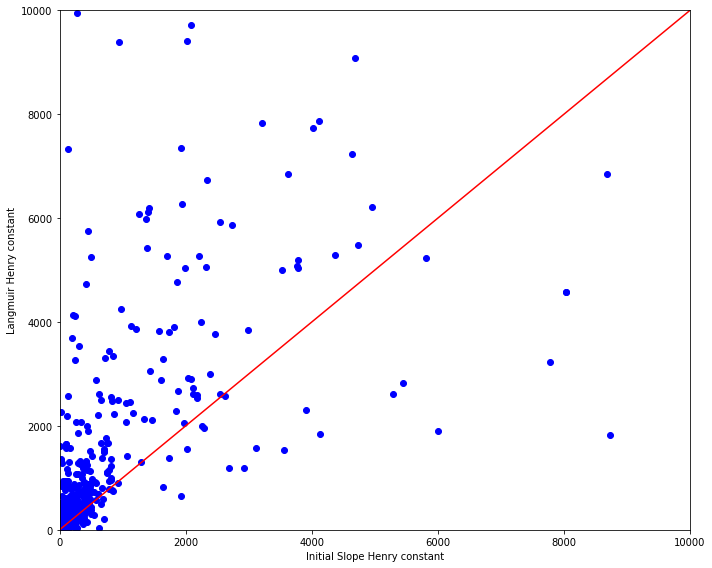

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
slope_henries = henry_coeff_df_henry['henry_constant'].values
langmuir_henries = henry_coeff_df_langmuir['henry_constant'].values
for i in range(len(slope_henries)):
    if np.isnan(slope_henries[i]) or np.isnan(langmuir_henries[i]):
        continue
    ax.scatter(slope_henries[i], langmuir_henries[i], c='b')
ax.plot([0,1e11], [0, 1e11], c='r')
ax.set_xlim([0, 10000])
ax.set_ylim([0, 10000])
ax.set_xlabel('Initial Slope Henry constant')
ax.set_ylabel('Langmuir Henry constant')
plt.tight_layout()
plt.show()


#### Run this for adsorption isotherm graphs of the files that we were not able to determine a Henry coefficient

Number of messed up isotherms: 235
10.1021acs.jpcc.5b01519.Isotherm20


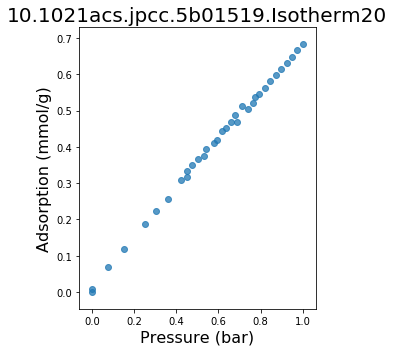

10.1021Jp074889i.Isotherm69


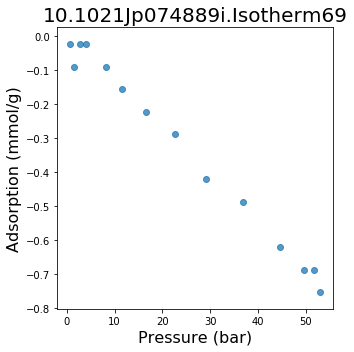

10.1016j.memsci.2011.09.040.Isotherm4


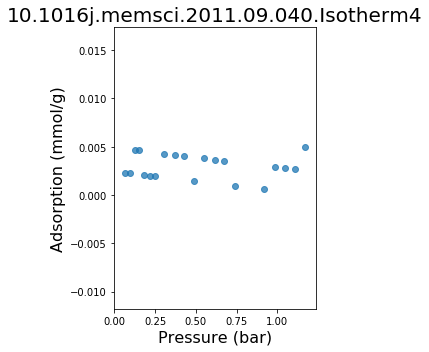

10.1021ic200937u.Isotherm5


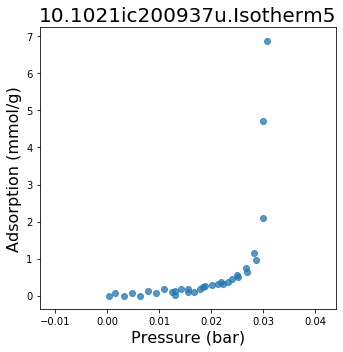

10.1016j.micromeso.2008.11.020.Isotherm3


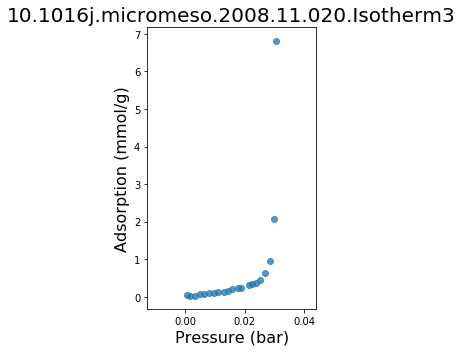

In [21]:
print('Number of messed up isotherms: {:d}'.format(len(messed_up_isotherms_langmuir)))
for messed_up_isotherm in messed_up_isotherms_langmuir[:5]:
    print(messed_up_isotherm)
    pressure, adsorption = read_isotherm_and_convert_units(messed_up_isotherm)
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.scatter(pressure, adsorption, marker='o', alpha=0.75)
    plt.xlabel('Pressure (bar)', fontsize=16)
    plt.ylabel('Adsorption (mmol/g)', fontsize=16)
    plt.title(messed_up_isotherm, fontsize=20)
    plt.tight_layout()
    plt.show()

In [22]:
def plot_isotherm_with_fits(filename, gas, material, outfile, not_save=True):
    try:
        #henry, rmse, n, n_del = find_optimal_henry(filename, 0.02)
        henry, rmse, srmse, n_del, M, K = find_optimal_henry_langmuir(filename)
        henry2, rmse2, n2, n_del2 = find_optimal_henry(filename, 0.005)
    except Exception as e:
        print(e)
        raise Exception('Oops! The isotherm was messed up!')
    
    pressure, adsorption = read_isotherm_and_convert_units(filename)
    new_p = np.linspace(0, pressure[-1], num=100)
    new_n = (M * K * new_p) / (1 + K * new_p)
    new_n2 = henry2 * new_p
    H = M * K
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(pressure[:n_del], adsorption[:n_del], marker='x', color='k', zorder=999)
    ax.scatter(pressure[n_del:], adsorption[n_del:], label='Experimental Data', color='b', zorder=999)
    ax.plot([0, pressure[-1]], [0, pressure[-1] * henry], color='#911eb4', label='Langmuir-derived Henry Coefficient', lw=2)
    ax.plot(new_p, new_n, label='Langmuir Fit', color='green', lw=1.9, ls='--')
    #ax.plot(new_p, new_n2, label='Initial Slope Henry Coefficient', color='cyan', lw=1.9)
    plt.tick_params(labelsize=12)
    plt.legend(prop={'size':12})
    plt.xlabel('Pressure [bar]', size=14)
    plt.ylabel('Adsorption [mmol/g]', size=14)
    plt.ylim([0, np.max(adsorption)*1.2])
    #plt.title('{} adsorption in {}: {}\nLangmuir-derived Henry Coeff: {:.2f} mmol/g-bar\nInitial Slope Henry Coeff: {:.2f} mmol/g-bar\nRMSE: {:.4f}\nsRMSE: {:.4f}\nK: {:.2f}, M: {:.2f}\nM/K: {:.2e}'.format(gas, material, filename, henry, henry2, rmse, srmse, K, M, M/K))
    plt.title('{} adsorption in {}, H = {:.3f}'.format(gas, material, H), size=16)
    plt.grid('on')
    if srmse > 0.15:
        ax.set_facecolor((1.0, 0.47, 0.42))
    if not not_save:
        plt.savefig('pics/' + outfile + '_clean.png', dpi=300, format='png')
    plt.show()
    print('-----------------------------------------------------------')
    return

10.1002aic.690460807.isotherm13


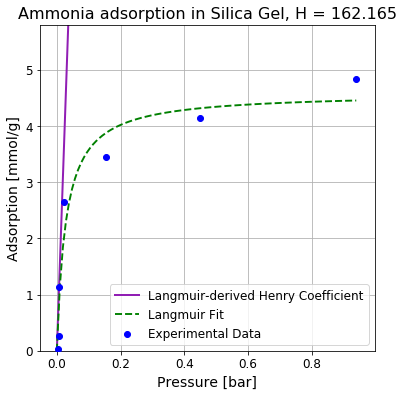

-----------------------------------------------------------
10.1039B807470d.isotherm11


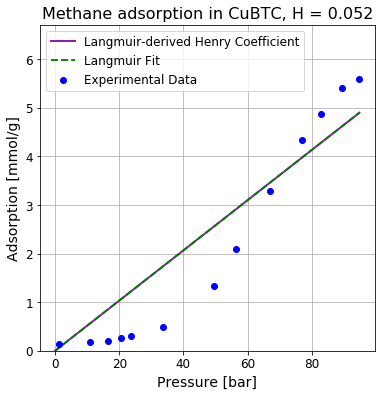

-----------------------------------------------------------
10.1021Jp203607s.isotherm11


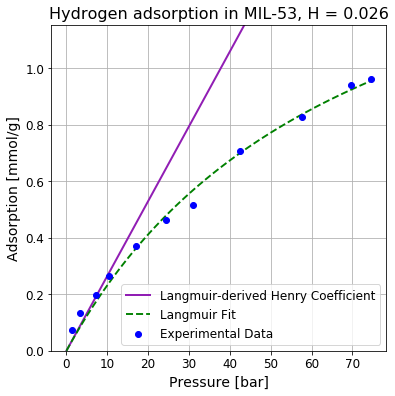

-----------------------------------------------------------
10.1021acs.langmuir.5b00833.Isotherm9


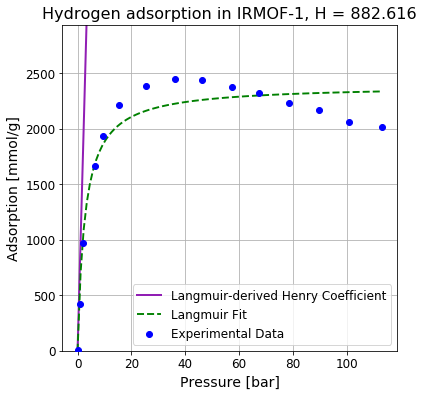

-----------------------------------------------------------
10.1021La803085h.isotherm15


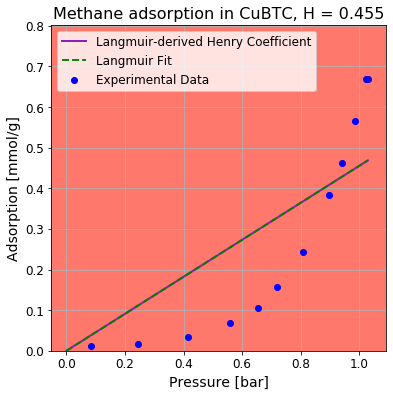

-----------------------------------------------------------
10.1021Jp211280m.isotherm12


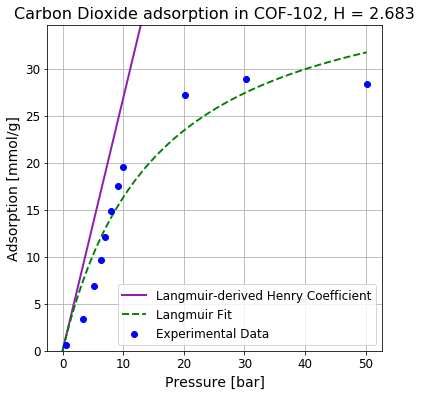

-----------------------------------------------------------
10.1021La061149c.Isotherm3


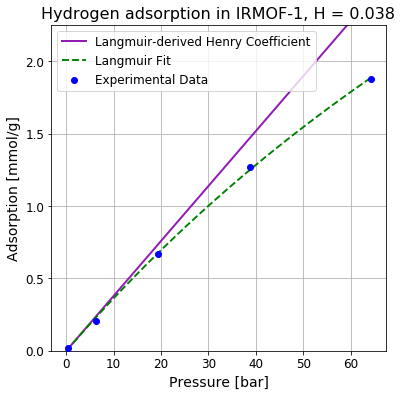

-----------------------------------------------------------
10.1021Jp3099768.Isotherm2


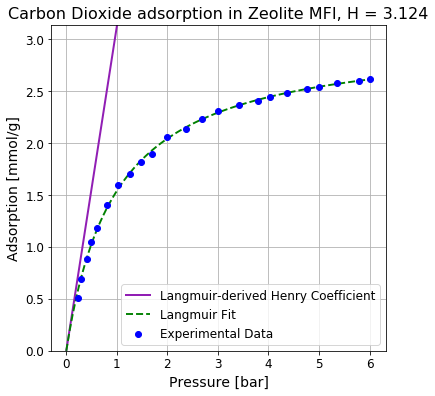

-----------------------------------------------------------
10.1016j.micromeso.2012.02.034.Isotherm23


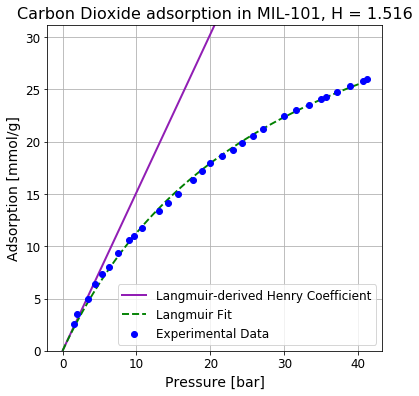

-----------------------------------------------------------
10.1021Ja901061j.isotherm5


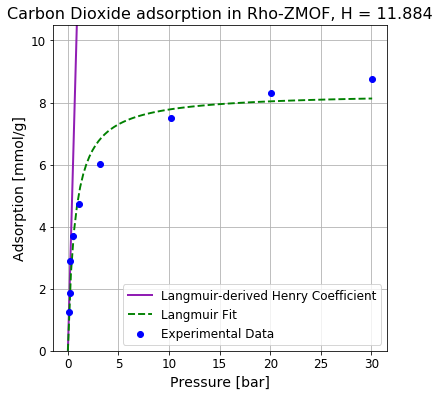

-----------------------------------------------------------


In [23]:
n = 10
for i in range(n):
    idx = random.choice(np.arange(len(henry_coeff_df_langmuir.index[henry_coeff_df_langmuir['ok']==True])))
    gas = henry_coeff_df_langmuir.iat[idx, 0]
    material = henry_coeff_df_langmuir.iat[idx, 2]

    filename = henry_coeff_df_langmuir.iat[idx, 5]
    print(filename)
    outfile = 'langmuir_fig_' + str(i)
    try:
        plot_isotherm_with_fits(filename, gas, material, outfile, False)
    except:
        print('what happened')
        continue

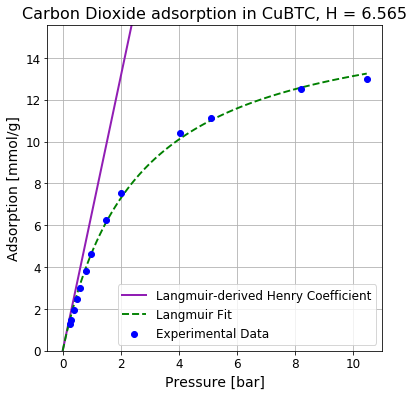

-----------------------------------------------------------


In [24]:
plot_isotherm_with_fits('10.126002636174.33.2.223.Isotherm34', 'Carbon Dioxide', 'CuBTC', 'for_paper_isotherm', False)

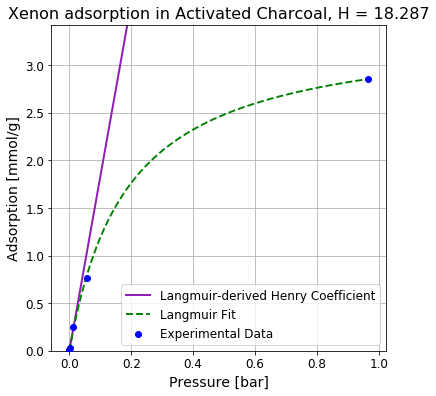

-----------------------------------------------------------


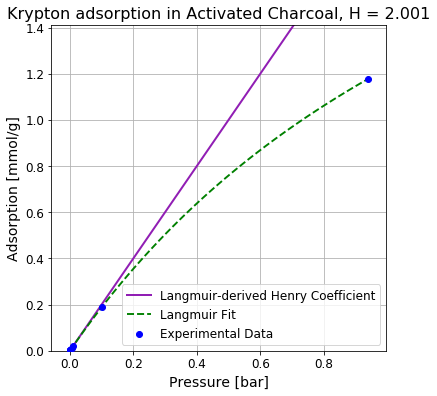

-----------------------------------------------------------


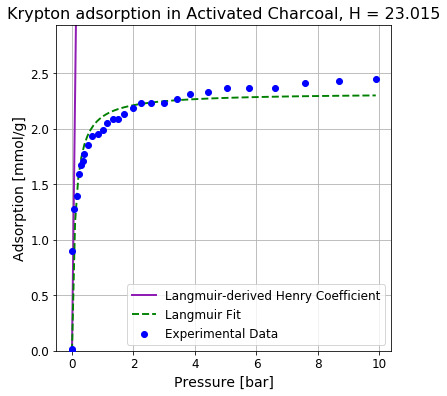

-----------------------------------------------------------


In [25]:
plot_isotherm_with_fits('10.3327jnst.36.818.Isotherm17', 'Xenon', 'Activated Charcoal', 'asdf')
plot_isotherm_with_fits('10.3327jnst.36.818.Isotherm12', 'Krypton', 'Activated Charcoal', 'asdf')
plot_isotherm_with_fits('10.1016j.cej.2014.09.123.Isotherm10', 'Krypton', 'Activated Charcoal', 'asdf')

### Lets try analyzing the Henry Coefficients and get rid of outliers

In [26]:
henry_coeff_df_langmuir

,gas,inchikey,material,hashkey,henry_constant,filename,ok
0,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.659408,10.8888s10450-012-9407-1.Isotherm11,True
1,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.231894,10.8888s10450-012-9407-1.Isotherm1,True
2,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.438559,10.8888jp206959k.Isotherm17,True
3,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,3.375608,10.8888Ja909263x.Isotherm2,True
4,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,0.868313,10.8888j.cej.2011.01.096.isotherm4b,True
5,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.811834,10.1039C4ee01009d.Isotherm22,True
6,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.343915,10.1039C4ee01009d.Isotherm21,True
7,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,2.763365,10.1039C4ee01009d.Isotherm20,True
8,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.439569,10.1039C4ee01009d.Isotherm19,True
9,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,ZIF-8,NIST-MATDB-b2dc02871a66ac38e4b195796cf3e00b,1.282093,10.1039C4ee01009d.Isotherm18,True


In [27]:
def z_score_detection(henry_coeff_df, z_threshold, exclude_z_bool=False):
    new_df = pd.DataFrame(columns=['z_score', 'z_bool'])
    for gas in henry_coeff_df.gas.unique():
        if not exclude_z_bool:
            henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True]['henry_constant'].values
        else:
            henries = henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['z_bool'] == True]['henry_constant'].values
        if len(henries) == 0:
            continue
        mean_henry = np.nanmean(henries)
        stdev_henry = np.nanstd(henries)
        if len(henries) > 1:
            z_scores = [(henry - mean_henry) / stdev_henry for henry in henries]
            if not exclude_z_bool:
                temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True].index,
                                       data={'z_score': z_scores, 'z_bool': np.less(np.abs(z_scores), z_threshold)})
            else:
                temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['z_bool'] == True].index,
                                       data={'z_score': z_scores, 'z_bool': np.less(np.abs(z_scores), z_threshold)})
        else:
            if not exclude_z_bool:
                temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['ok'] == True].index,
                                    data={'z_score': np.nan, 'z_bool': True})
            else:
                temp_df = pd.DataFrame(index=henry_coeff_df.loc[henry_coeff_df['gas'] == gas].loc[henry_coeff_df['z_bool'] == True].index,
                                    data={'z_score': np.nan, 'z_bool': True})
        new_df = pd.concat([new_df, temp_df], sort=False)
    if 'z_score' in henry_coeff_df.columns:
        del henry_coeff_df['z_score']
    if 'z_bool' in henry_coeff_df.columns:
        del henry_coeff_df['z_bool']
    
    henry_coeff_df = henry_coeff_df.join(new_df, how='left')
    henry_coeff_df['z_bool'].fillna(False, inplace=True)
    return henry_coeff_df
henry_coeff_df_langmuir = z_score_detection(henry_coeff_df_langmuir, 3.0)
henry_coeff_df_langmuir = z_score_detection(henry_coeff_df_langmuir, 3.0, True)
henry_coeff_df_henry = z_score_detection(henry_coeff_df_henry, 3.0)
henry_coeff_df_henry = z_score_detection(henry_coeff_df_henry, 3.0, True)
#henry_coeff_df = z_score_detection(henry_coeff_df, 1.5, True)

In [28]:
henry_coeff_df_langmuir.loc[henry_coeff_df_langmuir.z_bool == True].sort_values(by='henry_constant', ascending=False).head(20)

,gas,inchikey,material,hashkey,henry_constant,filename,ok,z_score,z_bool
1592,Formaldehyde,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Zeolite NaX,NIST-MATDB-1e130146cc6d11f05471f1e054d640c8,746718.863262,10.1016j.jhazmat.2015.07.078.Isotherm10,True,1.261653,True
1591,Formaldehyde,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Zeolite NaX,NIST-MATDB-1e130146cc6d11f05471f1e054d640c8,668178.308451,10.1016j.jhazmat.2015.07.078.Isotherm4,True,1.013896,True
3501,Formaldehyde,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Zeolite Na-Y,NIST-MATDB-c422d2007633d4bce61c708dc86bfc2d,315663.202636,10.1016j.jhazmat.2015.07.078.Isotherm1,True,-0.098120,True
1816,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Na-Rho-ZMOF,NIST-MATDB-121099da5c9e0772a6f7a19e407c83ab,155232.579755,10.1021Jp1033273.Isotherm16,True,2.596368,True
3345,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Zeolite 4A,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,148191.524210,10.1021Jp805923k.Isotherm3-1,True,2.466113,True
1542,Ethanol,LFQSCWFLJHTTHZ-UHFFFAOYSA-N,Zeolite Na-A,NIST-MATDB-9ee35322ac5ddba224d845a03c651b29,130161.825246,10.1252Jcej.37.67.isotherm4,True,2.132576,True
3337,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Zeolite 4A,NIST-MATDB-081a0818678716f502aee0b58ac1b30a,117098.194357,10.1021Jp805923k.Isotherm2-2,True,2.381027,True
2455,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,101779.361148,10.1021Ct500094w.Isotherm6,True,2.020924,True
2667,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,CPO-27-Ni,NIST-MATDB-5b3ad76c63b1ce87a685648f69a4de28,93688.212962,10.1039C4cs00078a.Isotherm3,True,1.830724,True
247,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,Zeolite 5A,NIST-MATDB-035dc75dddd00241bd76627f78cbef2d,92469.050306,10.1021Je800900a.Isotherm53,True,1.802065,True


In [29]:
henry_coeff_df_langmuir['log_henry'] = np.log10(henry_coeff_df_langmuir['henry_constant'])
henry_coeff_df_langmuir['mybool'] = henry_coeff_df_langmuir['log_henry'] > -5
henry_coeff_df_henry['log_henry'] = np.log10(henry_coeff_df_henry['henry_constant'])
henry_coeff_df_henry['mybool'] = henry_coeff_df_henry['log_henry'] > -5

In [30]:
henry_coeff_df_langmuir.sort_values(by='mybool', ascending=True).head(10)

,gas,inchikey,material,hashkey,henry_constant,filename,ok,z_score,z_bool,log_henry,mybool
3156,Ethene,VGGSQFUCUMXWEO-UHFFFAOYSA-N,ZIF-7,NIST-MATDB-8cae84fb784881ac1d577dea3d006c4e,NaN,10.1002chem.201100958.Isotherm22,False,NaN,False,NaN,False
2432,N-propane,ATUOYWHBWRKTHZ-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,NaN,10.1021La2030473.isotherm17,False,NaN,False,NaN,False
2431,N-propane,ATUOYWHBWRKTHZ-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,NaN,10.1021La2030473.isotherm18,False,NaN,False,NaN,False
2428,Propene,QQONPFPTGQHPMA-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,NaN,10.1021La2030473.isotherm19,False,NaN,False,NaN,False
3858,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,Norit R1 Extra,NIST-MATDB-0430f3ede7fd0f8d58eb6cf454011ef2,NaN,10.1016j.seppur.2014.08.021.Isotherm3,False,NaN,False,NaN,False
2425,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,Mg-MOF-74,NIST-MATDB-f5e80ffaaaf05f4ed655664fd22defb9,0.000001,10.1016j.memsci.2011.05.001.Isotherm24,True,-0.073886,True,-5.894991,False
1865,Carbon Dioxide,CURLTUGMZLYLDI-UHFFFAOYSA-N,IRMOF-8,NIST-MATDB-9d023a670a2aedb5225d9cd365e24210,NaN,10.1021Jp307319u.isotherm2e,False,NaN,False,NaN,False
3868,Methane,VNWKTOKETHGBQD-UHFFFAOYSA-N,[Cu(BF4)2(bpp)2]n,NIST-MATDB-53e35057427decf192a1effd7d881922,NaN,10.1016j.micromeso.2015.03.021.Isotherm5,False,NaN,False,NaN,False
3563,Water,XLYOFNOQVPJJNP-UHFFFAOYSA-N,C6H10CuN3,NIST-MATDB-c8ef237d84290dbc0b2948cb057d6671,NaN,10.1021Ja800550a.Isotherm6,False,NaN,False,NaN,False
3871,N-Butane,IJDNQMDRQITEOD-UHFFFAOYSA-N,[Cu(BF4)2(bpp)2]n,NIST-MATDB-53e35057427decf192a1effd7d881922,NaN,10.1016j.micromeso.2015.03.021.Isotherm2,False,NaN,False,NaN,False


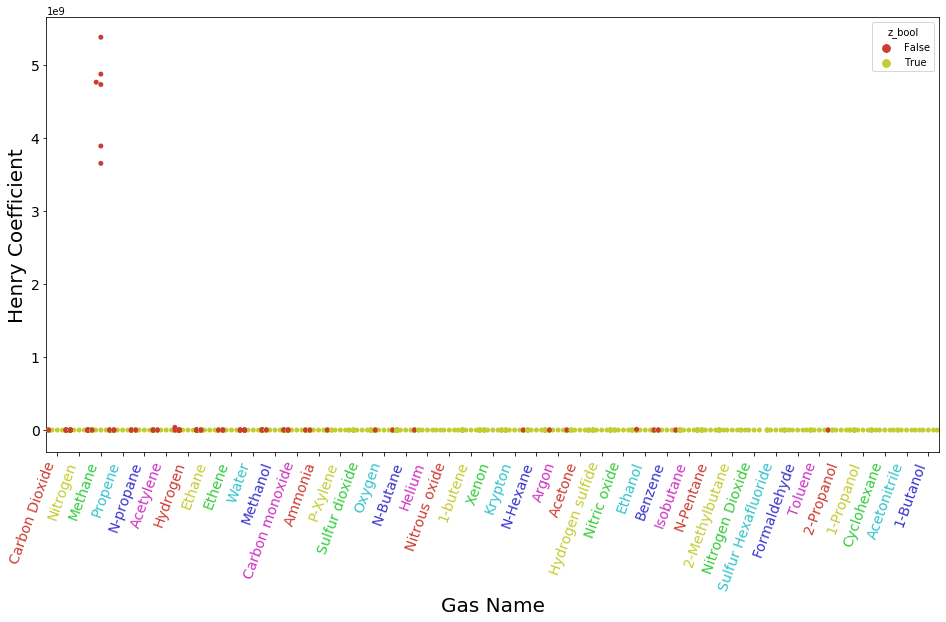

In [31]:
fig = plt.figure(figsize=(16,8))
pal = sns.hls_palette(6, l=.5, s=.6)
sp = sns.swarmplot(x='gas', y='henry_constant', hue="z_bool", palette=pal, data=henry_coeff_df_langmuir)
#plt.ylim([-1, 50000])
ax = plt.gca()
#ax.get_legend().remove()
plt.xticks(rotation=70, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Henry Coefficient', fontsize=20)
plt.xlabel('Gas Name', fontsize=20)
pal.as_hex()
n = len(pal)
for (i, xtick) in enumerate(ax.get_xticklabels()):
    xtick.set_color(pal[i%n])

In [32]:
def construct_henry_matrix(henry_coeff_df, method_for_multiple_isotherms, use_all=False):
    assert method_for_multiple_isotherms in ['median', 'mean']
    henry_matrix = np.empty(material_gas_df.shape)
    henry_matrix.fill(np.nan)

    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            ok_isotherms = henry_coeff_df.loc[(henry_coeff_df['inchikey'] == gas.split('_')[0]) & (henry_coeff_df['hashkey'] == material) & (henry_coeff_df['mybool'] == True)]
            if len(ok_isotherms['mybool'].values) != 0 or use_all:
                if method_for_multiple_isotherms == 'mean':
                    henry_matrix[i, j] = np.mean(ok_isotherms['henry_constant'].values)
                elif method_for_multiple_isotherms == 'median':
                    henry_matrix[i, j] = np.median(ok_isotherms['henry_constant'].values)
    return henry_matrix

henry_matrix_langmuir = construct_henry_matrix(henry_coeff_df_langmuir, 'median', use_all=False)
henry_matrix_henry = construct_henry_matrix(henry_coeff_df_henry, 'median', use_all=False)

In [33]:
def prune_matrix(henry_matrix, min_data_points, verbose=True):
    keep_row = np.ones(henry_matrix.shape[0], dtype=bool)
    keep_column = np.ones(henry_matrix.shape[1], dtype=bool)
    nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
    gases_cut = 0
    materials_cut = 0
    count = 0

    while True:
        for i_row in range(henry_matrix.shape[0]):
            if np.count_nonzero(~np.isnan(henry_matrix[i_row, keep_column])) < min_data_points:
                keep_row[i_row] = False

        for i_column in range(henry_matrix.shape[1]):
            if np.count_nonzero(~np.isnan(henry_matrix[keep_row, i_column])) < min_data_points:
                keep_column[i_column] = False

        if nb_kept_rows_and_columns == (np.sum(keep_row) + np.sum(keep_column)):
            break

        nb_kept_rows_and_columns = np.sum(keep_row) + np.sum(keep_column)
        count += 1

    materials_cut = np.sum(~keep_row)
    gases_cut = np.sum(~keep_column)

    if verbose:
        print("Number of materials cut: {}" .format(materials_cut))
        print("Number of gases cut: {}" .format(gases_cut))
        print('The remaining dimensions of the matrix are {} by {}'.format(henry_matrix.shape[0]-materials_cut,henry_matrix.shape[1]-gases_cut))
        print('The number of iterations of sparsing the matrix: {}'.format(count))
        print('The sparsity of the resulting matrix is {:.1f}%'.format(
            100*np.count_nonzero(np.isnan(henry_matrix[keep_row, :][:, keep_column]))/np.size(henry_matrix[keep_row, :][:, keep_column])))
    
    return keep_row, keep_column

keep_row_h, keep_column_h = prune_matrix(henry_matrix_henry, MIN_UNIQUE_ISOTHERMS)
new_henry_matrix_h = henry_matrix_henry[keep_row_h, :][:, keep_column_h]

keep_row_l, keep_column_l = prune_matrix(henry_matrix_langmuir, MIN_UNIQUE_ISOTHERMS)
new_henry_matrix_l = henry_matrix_langmuir[keep_row_l, :][:, keep_column_l]

Number of materials cut: 22
Number of gases cut: 1
The remaining dimensions of the matrix are 218 by 40
The number of iterations of sparsing the matrix: 2
The sparsity of the resulting matrix is 85.8%
Number of materials cut: 29
Number of gases cut: 1
The remaining dimensions of the matrix are 211 by 40
The number of iterations of sparsing the matrix: 2
The sparsity of the resulting matrix is 85.9%


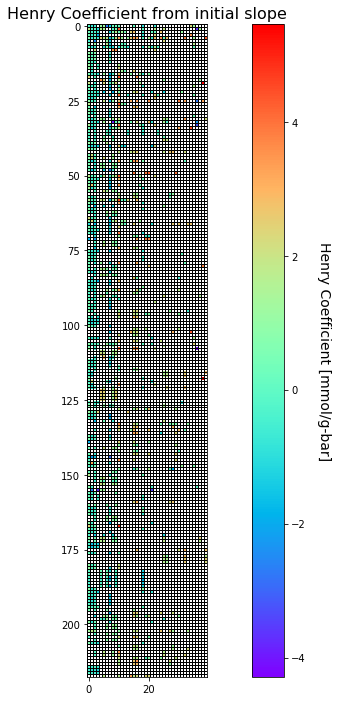

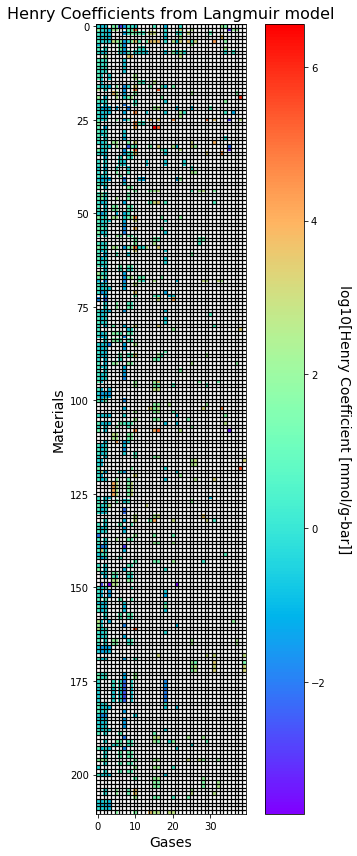

In [34]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
for y in range(new_henry_matrix_h.shape[0]):
    plt.plot([0-0.5, new_henry_matrix_h.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1, color='k')
for x in range(new_henry_matrix_h.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, new_henry_matrix_h.shape[0]-0.5], linewidth=1, color='k')
plt.imshow(np.log10(new_henry_matrix_h), interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('Henry Coefficient [mmol/g-bar]', fontsize=14, rotation=270, labelpad=25)
ax.set_title('Henry Coefficient from initial slope', fontsize=16)
plt.show()

fig = plt.figure(figsize=(6,12))
ax = plt.gca()
for y in range(new_henry_matrix_l.shape[0]):
    plt.plot([0-0.5, new_henry_matrix_l.shape[1]-0.5], [y-0.5, y-0.5], linewidth=1.25, color='k')
for x in range(new_henry_matrix_l.shape[1]):
    plt.plot([x-0.5, x-0.5], [0-0.5, new_henry_matrix_l.shape[0]-0.5], linewidth=1.25, color='k')
plt.imshow(np.log10(new_henry_matrix_l), interpolation='none', cmap='rainbow')
cbar = plt.colorbar()
cbar.set_label('log10[Henry Coefficient [mmol/g-bar]]', fontsize=14, rotation=270, labelpad=25)
ax.set_title('Henry Coefficients from Langmuir model', fontsize=16)
ax.set_xlabel('Gases', fontsize=14)
ax.set_ylabel('Materials', fontsize=14)
plt.tight_layout()
plt.savefig('pics/HenryMatrix_langmuir_model.png', dpi=300, format='png')
plt.show()

In [35]:
henry_matrix_df = pd.DataFrame(data=np.array(new_henry_matrix_h),
                                 columns=[material_gas_df.columns[i] for i in np.arange(material_gas_df.shape[1])[keep_column_h]],
                                 index=[material_gas_df.index[i] for i in np.arange(material_gas_df.shape[0])[keep_row_h]],
                                dtype=float)

henry_matrix_df.to_csv('data/henry_matrix_df_h_' + str(MIN_UNIQUE_ISOTHERMS) + '.csv')

henry_matrix_df = pd.DataFrame(data=np.array(new_henry_matrix_l),
                                 columns=[material_gas_df.columns[i] for i in np.arange(material_gas_df.shape[1])[keep_column_l]],
                                 index=[material_gas_df.index[i] for i in np.arange(material_gas_df.shape[0])[keep_row_l]],
                                dtype=float)

henry_matrix_df.to_csv('data/henry_matrix_df_l_' + str(MIN_UNIQUE_ISOTHERMS) + '.csv')

# Another idea: Interpolate adsorption at 0.1 bar

In [36]:
def find_adsorption_at_interpolation_value(isotherm_filename, interpolation_value):
    pressure, adsorption = read_isotherm_and_convert_units(isotherm_filename)
    assert np.all(np.diff(pressure) >= 0), 'Pressure is not sorted.'

    if pressure[0] > interpolation_value or pressure[-1] < interpolation_value:
        raise Exception('This isotherm requires extrapolation')
    pressure_diff = pressure - interpolation_value
    p_index_high = np.argmax(pressure_diff >= 0)
    p_index_low = p_index_high - 1
    #print('[{:d},{:d}]'.format(p_index_low, p_index_high))
    #print('[{:f},{:f}]'.format(pressure[p_index_low], pressure[p_index_high]))
    interpolated_adsorption = adsorption[p_index_low] \
            + (adsorption[p_index_high] - adsorption[p_index_low]) / (pressure[p_index_high] - pressure[p_index_low]) \
            * (interpolation_value - pressure[p_index_low])
    return interpolated_adsorption
interpolated_adsorption = find_adsorption_at_interpolation_value('10.1002cssc.201200907.isotherm3', 0.1)
interpolated_adsorption

3.42388876546471

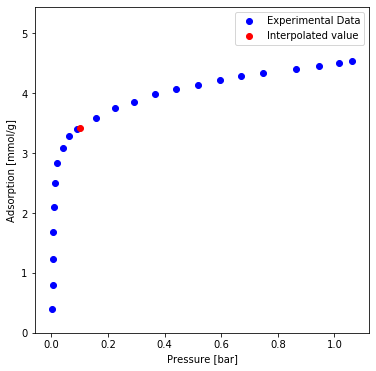

-----------------------------------------------------------


In [37]:
def plot_isotherm_with_interpolation(filename, interpolation_value):
    try:
        interpolated_adsorption = find_adsorption_at_interpolation_value(filename, interpolation_value)
    except Exception as e:
        print(e)
        raise Exception('Oops! The isotherm was messed up!')
    
    pressure, adsorption = read_isotherm_and_convert_units(filename)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(pressure, adsorption, label='Experimental Data', color='b', zorder=998)
    ax.scatter(interpolation_value, interpolated_adsorption, label='Interpolated value', color='r', zorder=999)
    plt.legend()
    plt.xlabel('Pressure [bar]')
    plt.ylabel('Adsorption [mmol/g]')
    plt.ylim([0, np.max(adsorption)*1.2])
    plt.show()
    print('-----------------------------------------------------------')
    return
plot_isotherm_with_interpolation('10.1002cssc.201200907.isotherm3', 0.1)

10.1039c5dt03137k.Isotherm29


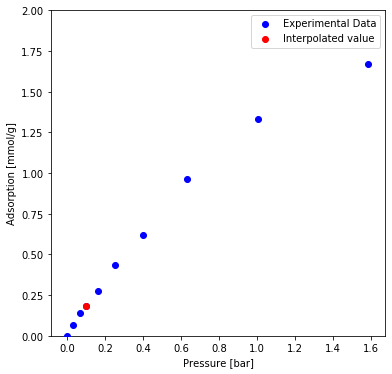

-----------------------------------------------------------
10.1021Jp308657x.isotherm3
This isotherm requires extrapolation
what happened
10.1002chem.201301806.isotherm5


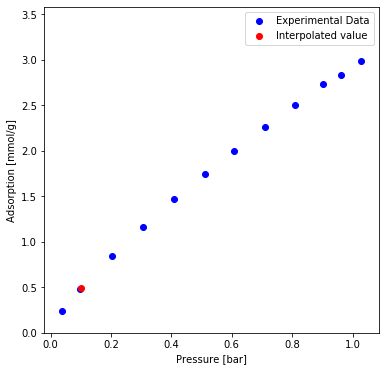

-----------------------------------------------------------
10.1039B807470d.isotherm6
This isotherm requires extrapolation
what happened
10.5012bkcs.2010.31.01.220.Isotherm1


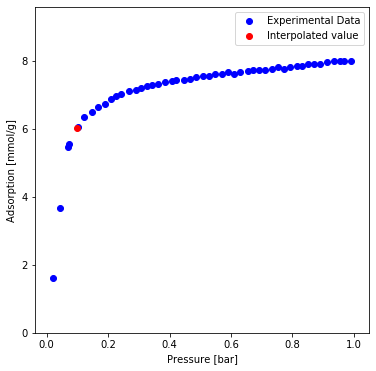

-----------------------------------------------------------
10.1016j.micromeso.2014.03.022.Isotherm34


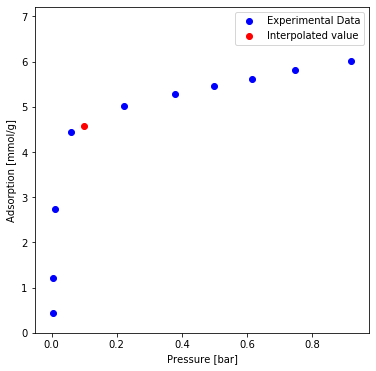

-----------------------------------------------------------
10.1021Jp809539w.isotherm17
This isotherm requires extrapolation
what happened
10.1016j.micromeso.2014.03.022.Isotherm51


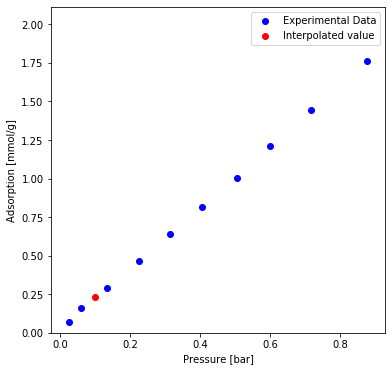

-----------------------------------------------------------
10.1039C3ra42213e.isotherm6


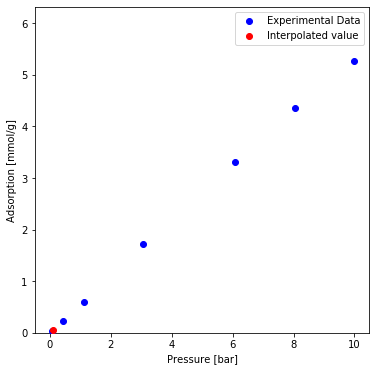

-----------------------------------------------------------
10.1039C0cc02496a.Isotherm7


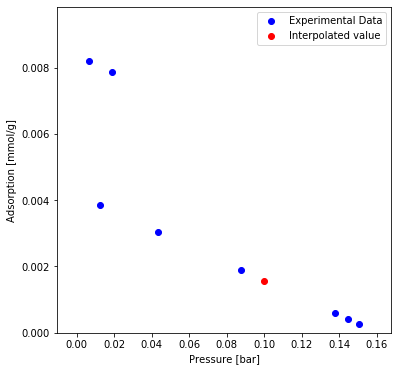

-----------------------------------------------------------
10.1016j.egypro.2011.01.090.Isotherm11
This isotherm requires extrapolation
what happened
10.1021Ct500094w.Isotherm4
This isotherm requires extrapolation
what happened
10.1039c3sc52633j.Isotherm12
This isotherm requires extrapolation
what happened
10.1016j.coal.2017.05.005.Isotherm24


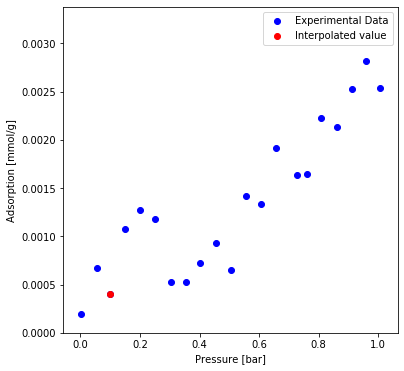

-----------------------------------------------------------
10.1021Jp051771y.Isotherm3-1
This isotherm requires extrapolation
what happened
10.1039C2cp23839j.Isotherm43
This isotherm requires extrapolation
what happened
10.1039C1cp20168a.Isotherm9
This isotherm requires extrapolation
what happened
10.1016j.micromeso.2014.02.016.Isotherm2


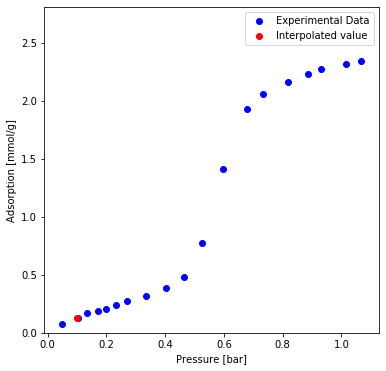

-----------------------------------------------------------
10.1039c4ta07115h.Isotherm7


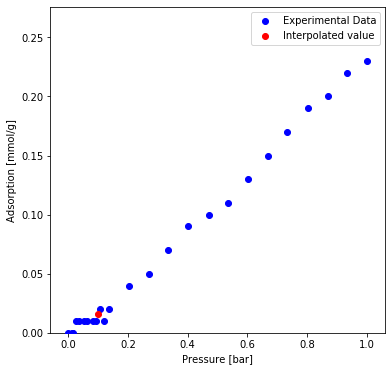

-----------------------------------------------------------
10.1021La4027128.isotherm9


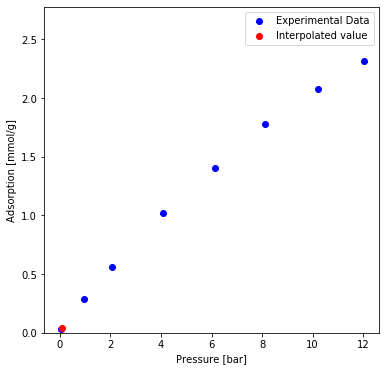

-----------------------------------------------------------
10.1039C4ra12432d.Isotherm18
This isotherm requires extrapolation
what happened
10.1021Jp3046356.Isotherm19
This isotherm requires extrapolation
what happened
10.1039C4cc06697a.Isotherm3


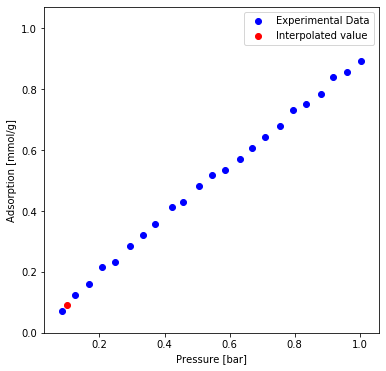

-----------------------------------------------------------
10.1021Jp200321y.isotherm19
This isotherm requires extrapolation
what happened
10.1016j.jngse.2016.02.052.Isotherm3
This isotherm requires extrapolation
what happened
10.1002cphc.201300225.Isotherm3
This isotherm requires extrapolation
what happened
10.1007s10973-013-3497-1.Isotherm5


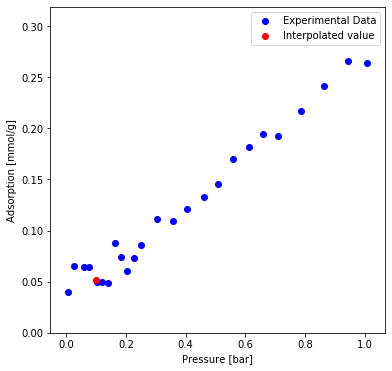

-----------------------------------------------------------
10.1039C4cc06697a.Isotherm6
This isotherm requires extrapolation
what happened
10.1002chem.201201340.isotherm9


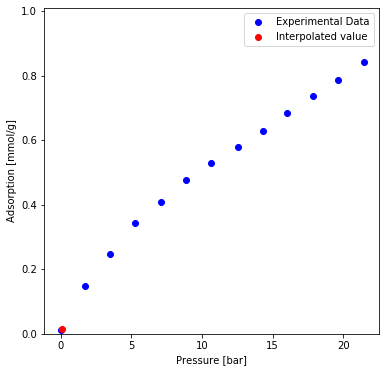

-----------------------------------------------------------
10.108008927020902865923.isotherm14
This isotherm requires extrapolation
what happened


In [38]:
n = 30
for i in range(n):
    idx = random.choice(np.arange(len(henry_coeff_df_langmuir)))
    gas = henry_coeff_df_langmuir.iat[idx, 0]
    material = henry_coeff_df_langmuir.iat[idx, 2]

    filename = henry_coeff_df_langmuir.iat[idx, 5]
    print(filename)
    outfile = 'langmuir_fig_' + str(i)
    try:
        plot_isotherm_with_interpolation(filename, 0.1)
    except:
        print('what happened')
        continue

In [39]:
def fit_interpolated_values(interpolated_value):
    messed_up_isotherms = []
    interpolated_df = pd.DataFrame(columns=['gas', 'inchikey', 'material', 'hashkey', 'adsorption_at_x', 'filename', 'ok'])
    for (i, material) in enumerate(material_gas_df.index):
        for (j, gas) in enumerate(material_gas_df.columns):
            if material not in material_gas_to_filename[gas].keys():
                continue
            filenames = material_gas_to_filename[gas][material]
            if len(filenames) < 1:
                continue

            for (k, filename) in enumerate(filenames):
                try:
                    interpolated_adsorption = find_adsorption_at_interpolation_value(filename, interpolated_value)
                    interpolated_df = pd.concat([interpolated_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'adsorption_at_x': [interpolated_adsorption], 'filename': [filename], 'ok': [True]})], ignore_index=True)
                except Exception as e:
                    #print('Exception!', e)
                    interpolated_df = pd.concat([interpolated_df, pd.DataFrame(data={'gas': [key_to_gas[gas.split('_')[0]]], 'inchikey': [gas.split('_')[0]], 'material': [key_to_material[material]], 'hashkey': [material], 'adsorption_at_x': [np.nan], 'filename': [filename], 'ok': [False]})], ignore_index=True)
                    messed_up_isotherms.append(filename)
    return interpolated_df, messed_up_isotherms

interpolated_df, messed_up_isotherms_interpolated = fit_interpolated_values(0.1)

In [40]:
interpolated_df.loc[interpolated_df.ok == True].values.shape

(1860, 7)

In [41]:
interpolated_df.loc[interpolated_df.ok == False].values.shape

(2310, 7)

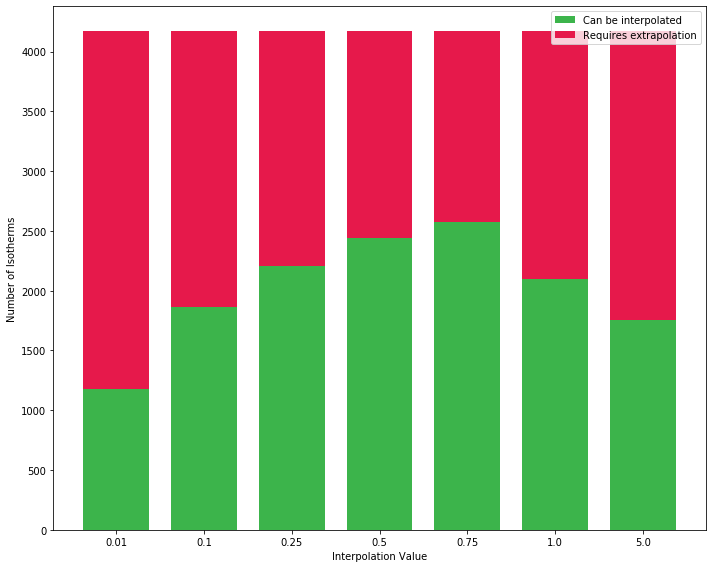

In [42]:
def sample_interpolated_values(interpolated_values):
    goods = np.zeros(len(interpolated_values))
    bads = np.zeros(len(interpolated_values))
    for (l, value) in enumerate(interpolated_values):
        n_good = 0
        n_bad = 0
        for (i, material) in enumerate(material_gas_df.index):
            for (j, gas) in enumerate(material_gas_df.columns):
                if material not in material_gas_to_filename[gas].keys():
                    continue
                filenames = material_gas_to_filename[gas][material]
                if len(filenames) < 1:
                    continue

                for (k, filename) in enumerate(filenames):
                    try:
                        interpolated_adsorption = find_adsorption_at_interpolation_value(filename, value)
                        n_good += 1
                    except Exception as e:
                        n_bad += 1
        goods[l] = n_good
        bads[l] = n_bad
    fig, ax = plt.subplots(figsize=(10,8))
    ax.bar(np.arange(len(interpolated_values)), goods, width=0.75, color='#3cb44b', label='Can be interpolated')
    ax.bar(np.arange(len(interpolated_values)), bads, width=0.75, color='#e6194B', bottom=goods, label='Requires extrapolation')
    ax.set_xlabel('Interpolation Value')
    ax.set_ylabel('Number of Isotherms')
    ax.set_xticks(np.arange(len(interpolated_values)))
    ax.set_xticklabels(interpolated_values)
    plt.legend()
    plt.tight_layout()
    plt.savefig('Interpolated_fig_' + str(MIN_UNIQUE_ISOTHERMS) + '.png', dpi=300, format='png')
    plt.show()
sample_interpolated_values([0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 5.0])
